In [1]:
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup


source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')



In [10]:
postal_codes_dict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_data = pd.DataFrame(columns=columns)
toronto_data

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    toronto_data = toronto_data.append({"PostalCode": postal_code, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)

# print number of rows of dataframe
toronto_data.shape[0]
toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government


In [14]:

c_df=pd.read_csv('http://cocl.us/Geospatial_data')

c_df.head(15)
c_df.shape

(103, 3)

In [22]:
p_df=toronto_data.join(c_df.set_index('Postal Code'), on='PostalCode')

p_df.shape

p_df.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Make a map using folium to show all of our data locations in the table above

In [25]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium
map = folium.Map(location=[43.6,-79.4], zoom_start=11)

for location in p_df.itertuples():
    label='Postal Code:{};  Borough:{};  Neighborhoods:{}'.format(location[1], location[2], location[3])
    label=folium.Popup(label, parse_html=True)    
    folium.CircleMarker([location[-2], location[-1]], radius=1, color='green', fill=True, fill_color='#8f9805', fill_opacity=0.7, parse_html=False).add_to(map) 
    folium.Circle(radius=500, popup=label, location=[location[-2], location[-1]], color='#8f9805', fill=True, fill_color='#8f9805').add_to(map) 
    
map

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

We are going to create a function to allow us to determine the closest postcode pair

In [30]:
from geopy.distance import great_circle

def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [31]:
coord = p_df[['Latitude', 'Longitude']]
distance, closest_point_index = closest_postcode(coord[:1], coord[~coord.index.isin([0])])
close_points = p_df[:1].append(p_df[closest_point_index+1:closest_point_index+2])
close_points

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
7,M3B,North York,Don Mills North,43.745906,-79.352188



Scatter plot of all of the data points with a legend allowing us to see the distance between two points on the top-right corner

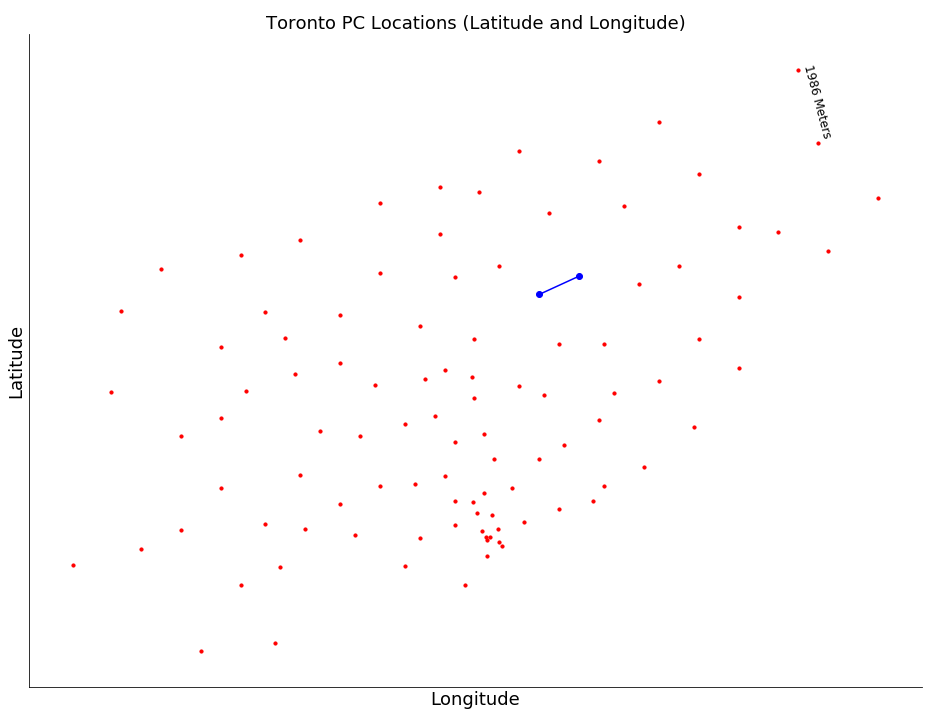

In [36]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16,12))
sp=fig.add_subplot(111)
sp.scatter(p_df['Longitude'],p_df['Latitude'], s=10, c='r', marker="o")
sp.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

sp.annotate('{} Meters'.format(distance), xy=(.859, .912), xycoords='figure fraction', ha='left', va='top', rotation=-75, fontsize=12)
sp.set_yticklabels([])
sp.set_xticklabels([])
sp.set_xticks([])
sp.set_yticks([])
sp.spines['top'].set_color(None)
sp.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('Toronto PC Locations (Latitude and Longitude)', fontsize=18)
sp.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 24})
plt.show()

Add a distance column to the existing dataframe to use as a radius

In [37]:
from math import isnan

for lat, lng, i in zip(p_df['Latitude'], p_df['Longitude'], p_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coord[~coord.index.isin([i])])
    p_df.at[i,'Distance'] = np.int64(distance//2)
    
p_df.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M3A,North York,Parkwoods,43.753259,-79.329656,993.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1018.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,614.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,934.0
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,256.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,1288.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1698.0
7,M3B,North York,Don Mills North,43.745906,-79.352188,993.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,702.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,342.0


We are now going to bring in our venues using our foursquare API accounts created during this course (credientials hidden since these are unique for each of these

In [45]:
# The code was removed by Watson Studio for sharing.

In [46]:

def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [47]:
first_pc=p_df.iloc[2, :]
url=format_url(first_pc['Latitude'], first_pc['Longitude'], first_pc['Distance'])

In [52]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
def get_venues(url):
    results=requests.get(url).json()
    venues=results['response']['groups'][0]['items']
    return json_normalize(venues)

In [53]:
v_df=get_venues(url)
v_df.head(15)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-54ea41ad498e9a11e9e13308-0,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",54ea41ad498e9a11e9e13308,362 King St E,CA,Toronto,Canada,Trinity St,...,"[{'label': 'display', 'lat': 43.65344672305267...",43.653447,-79.362017,NaN,M5A 1K9,ON,Roselle Desserts,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-53b8466a498e83df908c3f21-1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",53b8466a498e83df908c3f21,368 King St E,CA,Toronto,Canada,at Trinity St,...,"[{'label': 'display', 'lat': 43.65355870959944...",43.653559,-79.361809,NaN,NaN,ON,Tandem Coffee,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-574c229e498ebb5c6b257902-2,"[{'id': '52e81612bcbc57f1066b7a37', 'name': 'D...",574c229e498ebb5c6b257902,461 Cherry St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65324910177244...",43.653249,-79.358008,NaN,M5A 0H7,ON,Cooper Koo Family YMCA,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-50760559e4b0e8c7babe2497-3,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",50760559e4b0e8c7babe2497,497 King Street East,CA,Toronto,Canada,btwn Sackville St and Sumach St,...,"[{'label': 'display', 'lat': 43.65473505045365...",43.654735,-79.359874,NaN,M5A 1L9,ON,Body Blitz Spa East,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5612b1cc498e3dd742af0dc8-4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",5612b1cc498e3dd742af0dc8,573 King St E,CA,Toronto,Canada,at St Lawrence St,...,"[{'label': 'display', 'lat': 43.65636850543279...",43.656369,-79.356980,NaN,M5A 4L3,ON,Impact Kitchen,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ae5b91ff964a520a6a121e3-5,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",4ae5b91ff964a520a6a121e3,457 King St. E,CA,Toronto,Canada,Gilead Place,...,"[{'label': 'display', 'lat': 43.65394694263529...",43.653947,-79.361149,NaN,M5A 1L6,ON,Morning Glory Cafe,0,[],39686393
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-51ccc048498ec7792efc955e-6,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",51ccc048498ec7792efc955e,NaN,CA,NaN,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65561779974973...",43.655618,-79.356211,NaN,NaN,NaN,Corktown Common,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05ef964a520bff620e3-7,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",4ad4c05ef964a520bff620e3,"btwn Front, Cherry, Gardiner & Parliament",CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65024435658077...",43.650244,-79.359323,NaN,M5A 3C4,ON,The Distillery Historic District,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4af59046f964a520e0f921e3-8,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",4af59046f964a520e0f921e3,344 Queen St. E.,CA,Toronto,Canada,at Parliament St.,...,"[{'label': 'display', 'lat': 43.65567455427388...",43.655675,-79.364503,NaN,M5A 1S8,ON,Figs Breakfast & Lunch,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c3e1eaa6faac9b66dc60d76-9,"[{'id': '4bf58dd8d48988d1fa941735', 'name': 'F...",4c3e1eaa6faac9b66dc60d76,1 Trinity St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65007498933065...",43.650075,-79.361832,NaN,NaN,ON,Distillery Sunday Market,0,[],NaN


We are going to tidy up the venues dataframe that we just created

In [54]:

def tidy_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    tidy_df = df.loc[:,relevant_columns]
    tidy_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return tidy_df 

v_df = tidy_df(v_df)
v_df.head(15)

,Category,Lat,Lng,Name
0,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",43.653447,-79.362017,Roselle Desserts
1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.653559,-79.361809,Tandem Coffee
2,"[{'id': '52e81612bcbc57f1066b7a37', 'name': 'D...",43.653249,-79.358008,Cooper Koo Family YMCA
3,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.654735,-79.359874,Body Blitz Spa East
4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.656369,-79.356980,Impact Kitchen
5,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.653947,-79.361149,Morning Glory Cafe
6,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.655618,-79.356211,Corktown Common
7,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",43.650244,-79.359323,The Distillery Historic District
8,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.655675,-79.364503,Figs Breakfast & Lunch
9,"[{'id': '4bf58dd8d48988d1fa941735', 'name': 'F...",43.650075,-79.361832,Distillery Sunday Market


In [55]:
v_df.loc[0, 'Category']

[{'id': '4bf58dd8d48988d16a941735',
  'name': 'Bakery',
  'pluralName': 'Bakeries',
  'shortName': 'Bakery',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
   'suffix': '.png'},
  'primary': True}]

In [56]:
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

v_df['Category'] = v_df.apply(get_category_name, axis=1)
v_df.head(15)

,Category,Lat,Lng,Name
0,Bakery,43.653447,-79.362017,Roselle Desserts
1,Coffee Shop,43.653559,-79.361809,Tandem Coffee
2,Distribution Center,43.653249,-79.358008,Cooper Koo Family YMCA
3,Spa,43.654735,-79.359874,Body Blitz Spa East
4,Restaurant,43.656369,-79.356980,Impact Kitchen
5,Breakfast Spot,43.653947,-79.361149,Morning Glory Cafe
6,Park,43.655618,-79.356211,Corktown Common
7,Historic Site,43.650244,-79.359323,The Distillery Historic District
8,Breakfast Spot,43.655675,-79.364503,Figs Breakfast & Lunch
9,Farmers Market,43.650075,-79.361832,Distillery Sunday Market



Get all of the venues in each of the postcodes

In [78]:
def get_all_venues(postcodes, lat, lng, radius):
    vlist=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url=format_url(lat, lng, radius)
        results=requests.get(url).json()['response']['groups'][0]['items']
        vlist.append([(postcode, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name'])
            for v in results])
    venues=pd.DataFrame([item for vlist in vlist for item in vlist])
    venues.columns = ['PostalCode', 'PostalCode Latitude', 'PostalCode Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category']
    
    return venues

In [79]:
venues=get_all_venues(p_df['PostalCode'], p_df['Latitude'], p_df['Longitude'], p_df['Distance'])

venues.head(15)
venues.shape

(3413, 7)

In [80]:
pdiff = np.setdiff1d(p_df['PostalCode'].values,venues['PostalCode'].unique())
p_df[p_df['PostalCode']==pdiff[0]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0



We also want to look at the number of venues in each postcode

In [81]:

vp=venues.groupby('PostalCode').count()
vp=pd.DataFrame(list(zip(vp.index, vp['Venue'])), columns=['PostalCode', '# of Venues']).set_index('PostalCode').join(p_df[['PostalCode','Distance']].set_index('PostalCode'), on='PostalCode').reset_index()
vp['Distance'] = np.int64(vp['Distance'])
vp.loc[len(vp.index)] = ['M5E', 0, 111]

vp.head(15)

,PostalCode,# of Venues,Distance
0,M1B,37,1698
1,M1C,11,1625
2,M1E,29,1205
3,M1G,4,913
4,M1H,23,913
5,M1J,25,1301
6,M1K,26,1112
7,M1L,29,1052
8,M1M,18,1112
9,M1N,14,1297


In [82]:
vp[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,33.135922
std,25.790654
min,0.000000
25%,14.000000
50%,27.000000
75%,45.000000
max,100.000000


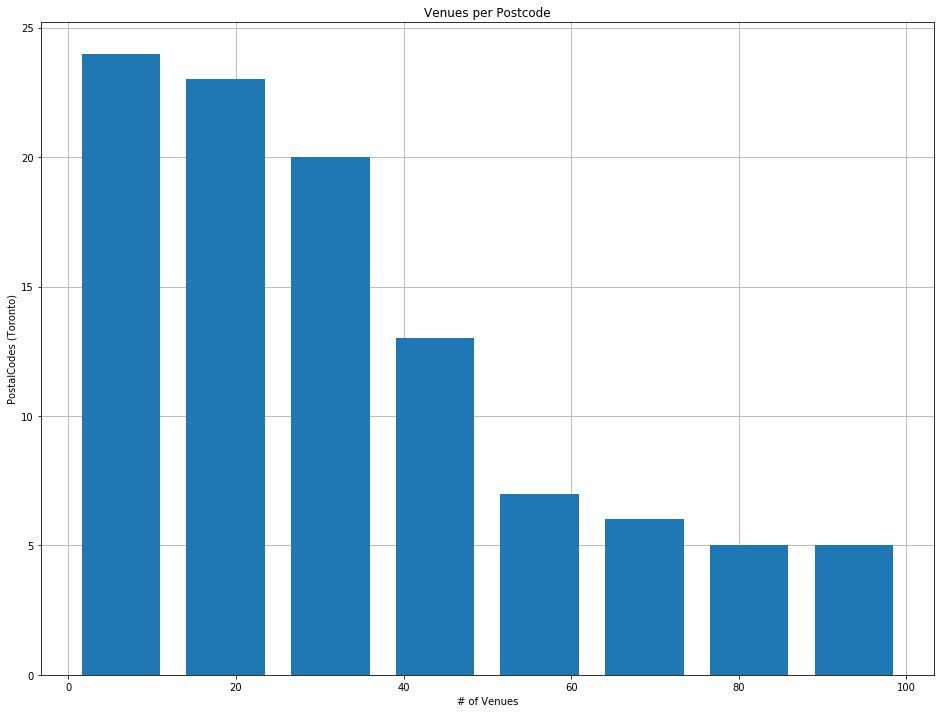

In [83]:
vp['# of Venues'].hist(bins=8, figsize=(16,12),zorder=2, rwidth=.75)
plt.xlabel('# of Venues')
plt.ylabel('PostalCodes (Toronto)')
plt.title('Venues per Postcode')

plt.show()

On top of venues in each postcode, let's take a look at density distribution of venues in each postcode

In [84]:
dvp=venues.groupby('PostalCode').count()
dvp=pd.DataFrame(list(zip(dvp.index, dvp['Venue'])), columns=['PostalCode', 'Density']).set_index('PostalCode').join(p_df[['PostalCode','Distance']].set_index('PostalCode'), on='PostalCode').reset_index()
dvp['Density'] = np.int64(dvp['Density']/(dvp['Distance']/1000))
dvp.loc[len(vp.index)] = ['M5E', 0, 111]

dvp.head(15)

,PostalCode,Density,Distance
0,M1B,21,1698.0
1,M1C,6,1625.0
2,M1E,24,1205.0
3,M1G,4,913.0
4,M1H,25,913.0
5,M1J,19,1301.0
6,M1K,23,1112.0
7,M1L,27,1052.0
8,M1M,16,1112.0
9,M1N,10,1297.0


In [85]:
dvp[['Density']].describe()

,Density
count,103.000000
mean,46.951456
std,48.267713
min,0.000000
25%,15.500000
50%,31.000000
75%,63.000000
max,271.000000


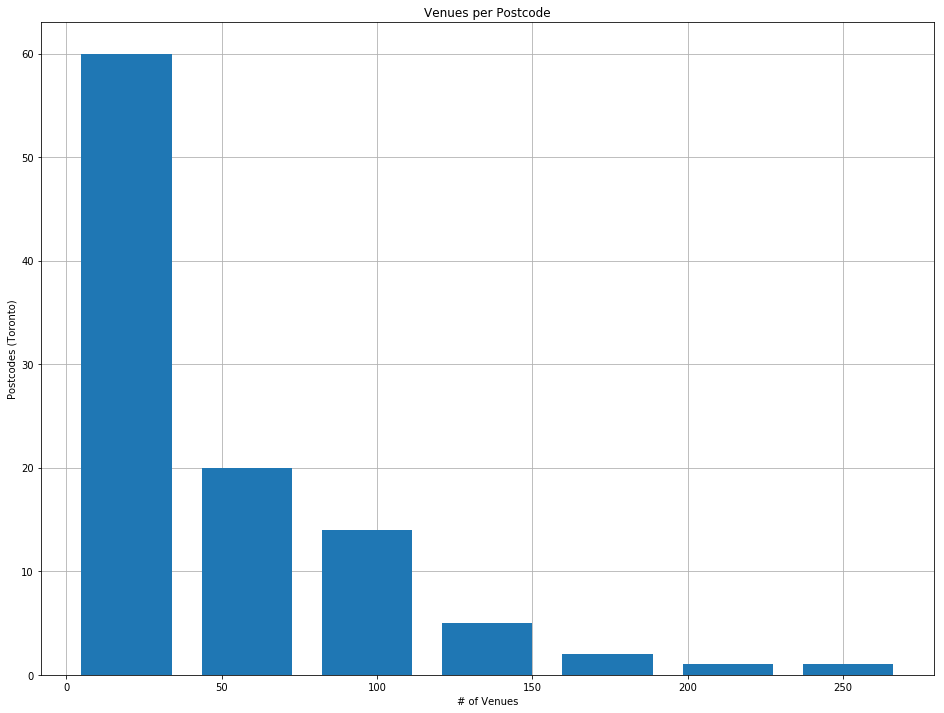

In [86]:
dvp['Density'].hist(bins=7, figsize=(16,12),zorder=2, rwidth=0.75)
plt.xlabel('# of Venues')
plt.ylabel('Postcodes (Toronto)')
plt.title('Venues per Postcode')

plt.show()

In [88]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

dis=[]
K=range(1,15)
for k in K:
    kmeans=KMeans(init="k-means++", n_clusters=k, n_init=12)
    kmeans.fit(dvp['Density'].values.reshape(-1, 1))
    dis.append(sum(np.min(cdist(dvp['Density'].values.reshape(-1, 1), kmeans.cluster_centers_, 'euclidean'), axis=1)) / dvp['Density'].shape[0])

In [89]:

ncluster=5
kmeans=KMeans(init= "k-means++", n_clusters=ncluster, n_init = 12)
kmeans.fit(dvp['Density'].values.reshape(-1, 1))
labels=kmeans.labels_

print(labels)

[3 3 3 3 3 3 3 0 3 3 0 0 0 0 0 0 3 3 0 3 3 3 4 0 0 0 3 0 0 0 3 3 3 3 3 3 3
 4 4 0 0 1 0 1 3 3 0 4 3 4 3 4 2 4 2 1 4 1 2 4 1 0 3 3 0 4 2 0 4 4 0 0 3 3
 0 0 1 4 3 3 0 4 4 4 3 0 0 0 0 0 3 0 3 3 3 3 3 3 3 3 3 3 3]


In [90]:
dvp['Cluster']=kmeans.labels_
dvp.head(15)

,PostalCode,Density,Distance,Cluster
0,M1B,21,1698.0,3
1,M1C,6,1625.0,3
2,M1E,24,1205.0,3
3,M1G,4,913.0,3
4,M1H,25,913.0,3
5,M1J,19,1301.0,3
6,M1K,23,1112.0,3
7,M1L,27,1052.0,0
8,M1M,16,1112.0,3
9,M1N,10,1297.0,3



After landing on k=5, we needed to find the centroids of each cluster

In [93]:
centroid=np.int64(round(dvp.groupby('Cluster').mean()['Density']))
f=dvp.groupby('Cluster').count()['PostalCode']
cinfo=pd.DataFrame([np.arange(0,5), centroid, f], index=['Cluster', 'Centroid','Postcodes']).T
cinfo.sort_values('Centroid', inplace=True)
cinfo.reset_index(drop=True, inplace=True)

cinfo

,Cluster,Centroid,Postcodes
0,3,14,45
1,0,39,32
2,4,84,16
3,1,126,6
4,2,216,4



We determine that the 5 clusters range from tier 1 through tier 5. Tier 1 being the lowest density and tier 5 being the highest density. The centroid is specified in the graph below.

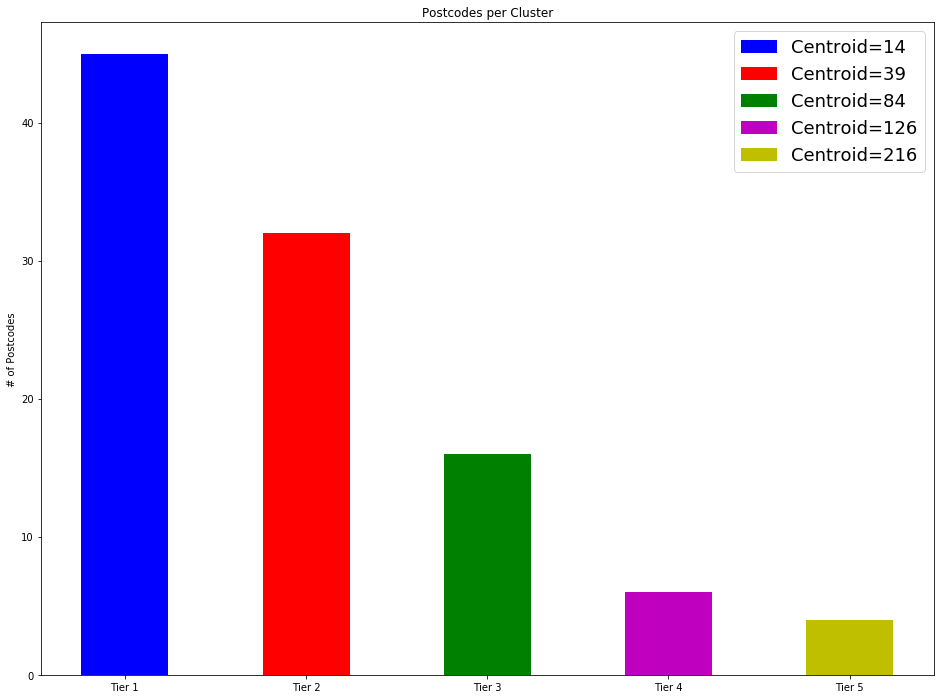

In [94]:
fig, ax=plt.subplots(figsize=(16,12))
tiers= ['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5']
colors=['b','r','g','m','y']
legend=[]

for id, cluster in enumerate(tiers):
    legend.append('Centroid={}'.format(cinfo['Centroid'][id]))
    bar=ax.bar(cluster, cinfo['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('# of Postcodes')
ax.set_title('Postcodes per Cluster')
plt.legend(legend, fontsize=18)

plt.show()

In [95]:
p_df = pd.concat([p_df[:56],p_df[57:],p_df[56:57]])
p_df['Cluster'] = kmeans.labels_
colors=['blue','red','green','magenta','yellow']
cvalues = cinfo['Cluster']

map=folium.Map(location=[43.6,-79.4], zoom_start=11)

for location in p_df.itertuples():
    cindex = cvalues.index[cvalues==location[-1]][0]
    label='Postal Code:{};  Borough:{};  Neighborhoods:{};{}'.format(location[1], location[2], location[3], cluster[cindex])
    label=folium.Popup(label, parse_html=True)    
    folium.Circle(radius=location[-2],popup=label,location=[location[-4], location[-3]],color=None,fill=True,fill_opacity=0.4,fill_color=colors[cindex]).add_to(map) 

map